# 교통 데이터 VDS을 이용한 머신러닝 분류 
## Decision Tree Classification

## I. 데이터 가져오기 
- 판다스를 이용하여 교통 데이터 가져오기

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('./daejeon_vds16.csv')
df.head()

Date  ToVol  SmVol  MeVol  LaVol  Speed  Occ.Rate
0  2017-04-02 0:00     43     34      9      0   50.3      1.90
1  2017-04-02 0:05     45     32     13      0   58.9      1.84
2  2017-04-02 0:10     46     34     12      0   50.6      1.87
3  2017-04-02 0:15     45     36      9      0   50.9      1.72
4  2017-04-02 0:20     27     13     13      1   62.2      1.12

array([<AxesSubplot:>], dtype=object)

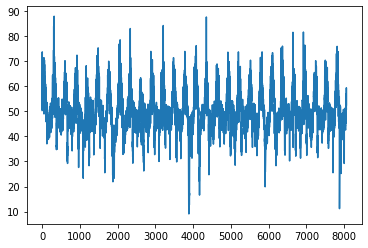

In [5]:
# 교통량 그림 그려보기
df_plt = df['Speed']
df_plt.plot(subplots=True)

- 5분 간격 데이터를 하루 동안 수집하면 그 갯수는 12(1시간) * 24 = 288
- 하루 동안 데이터를 그려보자 

## II. 라벨을 정하기
- 지도학습을 위해서 데이터를 Feature와 Label로 나누자.
- 무엇이 Feature이며 무엇이 Label 인가?
- 라벨은 무엇으로 정하는게 좋은가? 

In [6]:
def get_score(v):
    if v < 20:
        score = 'Jam'
    elif v < 40:
        score = 'Slow'
    else :
        score = 'Normal'
    return score

In [7]:
df["label_speed"] = df["Speed"].apply(lambda v: get_score(v))
df.head(5)

Date  ToVol  SmVol  MeVol  LaVol  Speed  Occ.Rate label_speed
0  2017-04-02 0:00     43     34      9      0   50.3      1.90      Normal
1  2017-04-02 0:05     45     32     13      0   58.9      1.84      Normal
2  2017-04-02 0:10     46     34     12      0   50.6      1.87      Normal
3  2017-04-02 0:15     45     36      9      0   50.9      1.72      Normal
4  2017-04-02 0:20     27     13     13      1   62.2      1.12      Normal

### 라벨을 위해 'label'의 텍스트는 범주형 혹은 숫자로 인코딩 해야한다

## 3. 데이터 가시화 

In [8]:
import matplotlib.pyplot as plt

## 4 머신러닝을 위한 입력 데이터 만들자
- 우선 무슨 문제를 풀어야 하는가?
- 지도학습이며 라벨이 있고, 제일 먼저 해보는 것은 분류를 해보자
- 즉, 교통 속도 라벨을 이용하여 해당 도로의 교통 흐름을 분류해보고 정확도를 논의하자

### 1) 입력 X와 출력 y의 값을 정하기

In [9]:
df['label_speed'].unique()

array(['Normal', 'Slow', 'Jam'], dtype=object)

- 머신러닝에서 특징(Feature)에 대하여, 그리고 라벨에 대하여 다시한번 복습합시다 

In [10]:
#feature_cols = ['ToVol', 'SmVol', 'Speed', 'Occ.Rate']
#feature_cols = ['ToVol', 'SmVol', 'LaVol', 'MeVol']
feature_cols = ['ToVol','Occ.Rate']
target_col = 'label_speed'
X = df[feature_cols]
y = df[target_col]

### 2) 출력용 라벨을 머신러닝 
- 텍스트를 숫자로 바꾸자
- One-Hot Encoding
- 자연어 처리에는 Embedding을 사용함. 
- Word2Vec 

In [11]:
class_dic = {'Jam':0, 'Slow':1, 'Normal':2}
y_ohc = y.apply(lambda z: class_dic[z])

In [12]:
y_ohc.head()

0    2
1    2
2    2
3    2
4    2
Name: label_speed, dtype: int64

### 3) 데이터를 훈련과 테스트로 나누자 
- (실전) 데이터를 validation을 포함해서 나눌수 있다.
- (해보기) 전체 데이터를 train : validation : test = 0.6: 0.2: 0.2 로 나누어라

In [13]:
from sklearn.model_selection import train_test_split

#from sklearn.model_selection import learning_curve, train_test_split, KFold,  ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y_ohc, test_size=0.20, random_state=30)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(6451, 2) (6451,)
(1613, 2) (1613,)


- 머신러닝에서는 훈련과정에서 입력 특징 데이터를 표준화, 정규화를 한다.
- 왜?

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. 머신러닝 모델을 만들자

In [16]:
import numpy as np
def plot_ml_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20)):   
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc='lower right')
    return plt

In [17]:
from sklearn import metrics   
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import ShuffleSplit, learning_curve

### 4 의사결정나무 (DecisionTreeClassifier)

In [18]:
from sklearn.tree import DecisionTreeClassifier    

In [19]:
m_tree = DecisionTreeClassifier()

- class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
- criterion : {“gini”, “entropy”, “log_loss”}, default=”gini”

In [20]:
m_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
pred = m_tree.predict(X_test)
acc_dt = metrics.accuracy_score(pred,y_test)
print('The accuracy of the Decision Tree is:', acc_dt)

The accuracy of the Decision Tree is: 0.9522628642281463


<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\Anaconda3\\envs\\tf-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

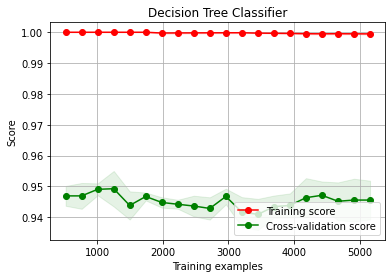

In [22]:
title = "Decision Tree Classifier"
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_ml_curve(m_tree, title, X_train, y_train,  cv=cv)

In [23]:
print(learning_curve(m_tree, X, y, cv=10, scoring='accuracy'))

(array([ 725, 2358, 3991, 5624, 7257]), array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.99957591, 0.99957591, 0.99915182, 0.99957591, 0.99957591,
        0.99957591, 0.99957591, 0.99957591, 0.99957591, 0.99957591],
       [0.99974944, 0.99974944, 0.99949887, 0.99974944, 0.99949887,
        0.99949887, 0.99949887, 0.99949887, 0.99949887, 0.99949887],
       [0.99928876, 0.99928876, 0.99911095, 0.99946657, 0.99928876,
        0.99928876, 0.99964438, 0.99911095, 0.99911095, 0.99911095],
       [0.99903541, 0.99903541, 0.99889762, 0.99944881, 0.99903541,
        0.99903541, 0.99931101, 0.99889762, 0.99903541, 0.99917321]]), array([[0.95910781, 0.96778191, 0.95167286, 0.95539033, 0.96401985,
        0.94789082, 0.94789082, 0.95037221, 0.97146402, 0.9528536 ],
       [0.95910781, 0.95415118, 0.94423792, 0.94423792, 0.95533499,
        0.95533499, 0.94044665, 0.95409429, 0.96526055, 0.94044665],